In [80]:
# import all packages used in this notebook
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from matplotlib.cm import tab10
from datetime import datetime

# add importable modules from src to system path for use in this notebook
import os
import sys
src_path = os.path.abspath(os.path.join(".."))
if src_path not in sys.path:
    sys.path.append(src_path)
import src

# Evaluate
Let's continue by evaluating our model forecasts in this notebook.

As before, we maintain alignment with the [`icenet-paper` repository](https://github.com/tom-andersson/icenet-paper).

### 1. Load forecasts, ground truth, and masks

We'll consider four forecasts in our evaluation against the OSI-SAF ground truth sea ice concentration data:
1. A linear trend baseline forecast, stored in `results/forecast_results/linear.nc`
2. A SEAS5 dynamical baseline, stored in `icenet-gan-data/forecasts/seas5/seas5_forecasts.nc`
3. A UNet forecast, from our best training [run](https://wandb.ai/andrewmcdonald/icenet-gan/runs/wq09bzy7/overview?workspace=user-andrewmcdonald) stored in `results/forecast_results/radiant-sponge-59-great-unet.nc`
3. A GAN forecast, from our best training [run](https://wandb.ai/andrewmcdonald/icenet-gan/runs/4iuiyi32/overview?workspace=user-andrewmcdonald) stored in `results/forecast_results/stilted-armadillo-99-great-gan.nc`

When considering deterministic forecast metrics, we'll use the mean forecast from our GAN ensemble.

We'll need to load in our active region masks to properly weight metrics in a spatial fashion as well.

In [2]:
linear_forecast = xr.open_dataarray(f"{src.config.forecast_results_folder}/linear.nc")
seas5_forecast = xr.open_dataarray(f"{src.config.forecast_data_folder}/seas5/seas5_forecasts.nc")
unet_forecast = xr.open_dataarray(f"{src.config.forecast_results_folder}/radiant-sponge-59-great-unet.nc")
gan_prob_forecast = xr.open_dataarray(f"{src.config.forecast_results_folder}/stilted-armadillo-99-great-gan.nc")
gan_forecast = gan_prob_forecast.sel(seed=["mean"])
true_forecast = xr.open_dataarray(f"{src.config.forecast_results_folder}/truth.nc")
forecast_mask = xr.open_dataarray(f"{src.config.forecast_results_folder}/mask.nc")


In [3]:
# filter seas5 forecast to test set dates, move leadtime to end, add ice_class dimension, add seed dimension
seas5_forecast = seas5_forecast.sel(time=linear_forecast.time)
seas5_forecast = seas5_forecast.transpose("time", "yc", "xc", "leadtime")
seas5_forecast = seas5_forecast.expand_dims("ice_class", -1)
seas5_forecast = seas5_forecast.expand_dims("seed", 0)
seas5_forecast

<xarray.DataArray (seed: 1, time: 17, yc: 432, xc: 432, leadtime: 6,
                   ice_class: 1)>
array([[[[[[0.],
           [0.],
           [0.],
           [0.],
           [0.],
           [0.]],

          [[0.],
           [0.],
           [0.],
           [0.],
           [0.],
           [0.]],

          [[0.],
           [0.],
           [0.],
           [0.],
           [0.],
           [0.]],
...
          [[0.],
           [0.],
           [0.],
           [0.],
           [0.],
           [0.]],

          [[0.],
           [0.],
           [0.],
           [0.],
           [0.],
           [0.]],

          [[0.],
           [0.],
           [0.],
           [0.],
           [0.],
           [0.]]]]]])
Coordinates:
  * time      (time) datetime64[ns] 2018-02-01 2018-03-01 ... 2019-06-01
  * yc        (yc) float64 5.388e+03 5.362e+03 ... -5.362e+03 -5.388e+03
  * xc        (xc) float64 -5.388e+03 -5.362e+03 ... 5.362e+03 5.388e+03
  * leadtime  (leadtime) int64 1 2 3 4 5 6
    lat       (yc, xc) float32 ...
    lon       (yc, xc) float32 ...
Dimensions without coordinates: seed, ice_class

In [4]:
# confirm that all shapes are (seed, dates, h, w, months, ice_class)
print(linear_forecast.shape)
print(seas5_forecast.shape)
print(unet_forecast.shape)
print(gan_forecast.shape)
print(true_forecast.shape)
print(forecast_mask.shape)

(1, 17, 432, 432, 6, 1)
(1, 17, 432, 432, 6, 1)
(1, 17, 432, 432, 6, 3)
(1, 17, 432, 432, 6, 3)
(1, 17, 432, 432, 6, 1)
(1, 17, 432, 432, 6, 1)


### 2. Compute binary accuracy
Binary accuracy, defined as the number of pixels correctly predicted as ice (SIC > 15%) and water (SIC < 15%), is the main metric used for evaluation in the original IceNet paper. Let's compute it here.

Throughout this notebook, we'll import functions from `src/evaluate.py` to abstract away implementation details and keep our focus on results.

In [36]:
binary_accuracies = {"Leadtime": [], "Linear": [], "SEAS5": [], "UNet": [], "GAN": []}

# compute binary accuracy for individual leadtimes
for leadtime in tqdm(range(1, 7)):
    binary_accuracies["Leadtime"].append(leadtime)
    binary_accuracies["Linear"].append(src.binary_accuracy(linear_forecast, true_forecast, forecast_mask, [leadtime]))
    binary_accuracies["SEAS5"].append(src.binary_accuracy(seas5_forecast, true_forecast, forecast_mask, [leadtime]))
    binary_accuracies["UNet"].append(src.binary_accuracy(unet_forecast, true_forecast, forecast_mask, [leadtime]))
    binary_accuracies["GAN"].append(src.binary_accuracy(gan_forecast, true_forecast, forecast_mask, [leadtime]))

# compute binary accuracy for all leadtimes
binary_accuracies["Leadtime"].append("All")
leads = list(range(1, 7))
binary_accuracies["Linear"].append(src.binary_accuracy(linear_forecast, true_forecast, forecast_mask, leads))
binary_accuracies["SEAS5"].append(src.binary_accuracy(seas5_forecast, true_forecast, forecast_mask, leads))
binary_accuracies["UNet"].append(src.binary_accuracy(unet_forecast, true_forecast, forecast_mask, leads))
binary_accuracies["GAN"].append(src.binary_accuracy(gan_forecast, true_forecast, forecast_mask, leads))

# construct dataframe
binary_accuracies_df = pd.DataFrame(binary_accuracies).set_index("Leadtime")
binary_accuracies_df

100%|██████████| 6/6 [00:09<00:00,  1.54s/it]


,Linear,SEAS5,UNet,GAN
Leadtime,,,,
1,0.887100,0.900908,0.855447,0.855698
2,0.876941,0.811257,0.805966,0.805090
3,0.874033,0.754157,0.757892,0.755051
4,0.873323,0.724212,0.725470,0.721581
5,0.872397,0.714133,0.779266,0.779486
6,0.874576,0.720008,0.813152,0.815744
All,0.876531,0.772724,0.790467,0.789719


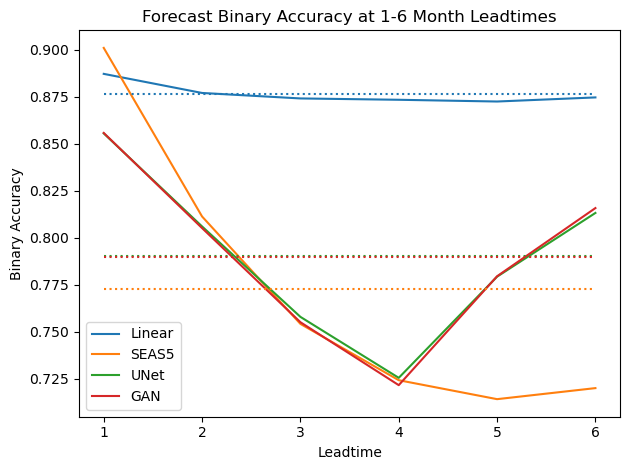

In [46]:
# plot against leadtime
fig, ax = plt.subplots()
binary_accuracies_df.drop("All").plot(ax=ax)
for i, model in enumerate(binary_accuracies_df.columns):
    plt.hlines(binary_accuracies_df[model].loc["All"], xmin=0, xmax=5, colors=tab10(i), linestyles=":")
plt.ylabel("Binary Accuracy")
plt.title("Forecast Binary Accuracy at 1-6 Month Leadtimes")
plt.tight_layout()
plt.show()

### 3. Compute binary F1
Accuracy is a useful metric, but it doesn't tell us the whole story when dealing with imbalanced data! 

Let's have a look at binary F1.

In [6]:
binary_f1s = {"Leadtime": [], "Linear": [], "SEAS5": [], "UNet": [], "GAN": []}

# compute binary f1 for individual leadtimes
for leadtime in tqdm(range(1, 7)):
    binary_f1s["Leadtime"].append(leadtime)
    binary_f1s["Linear"].append(src.binary_f1(linear_forecast, true_forecast, forecast_mask, [leadtime]))
    binary_f1s["SEAS5"].append(src.binary_f1(seas5_forecast, true_forecast, forecast_mask, [leadtime]))
    binary_f1s["UNet"].append(src.binary_f1(unet_forecast, true_forecast, forecast_mask, [leadtime]))
    binary_f1s["GAN"].append(src.binary_f1(gan_forecast, true_forecast, forecast_mask, [leadtime]))

# compute binary f1 for all leadtimes
binary_f1s["Leadtime"].append("All")
leads = list(range(1, 7))
binary_f1s["Linear"].append(src.binary_f1(linear_forecast, true_forecast, forecast_mask, leads))
binary_f1s["SEAS5"].append(src.binary_f1(seas5_forecast, true_forecast, forecast_mask, leads))
binary_f1s["UNet"].append(src.binary_f1(unet_forecast, true_forecast, forecast_mask, leads))
binary_f1s["GAN"].append(src.binary_f1(gan_forecast, true_forecast, forecast_mask, leads))

# construct dataframe
binary_f1s_df = pd.DataFrame(binary_f1s).set_index("Leadtime")
binary_f1s_df

100%|██████████| 6/6 [01:00<00:00, 10.11s/it]


,Linear,SEAS5,UNet,GAN
Leadtime,,,,
1,0.914212,0.924311,0.887384,0.887579
2,0.905322,0.857623,0.846271,0.844814
3,0.901313,0.813445,0.803332,0.800753
4,0.898731,0.788448,0.773918,0.769104
5,0.896540,0.778385,0.815352,0.815008
6,0.897447,0.781428,0.845164,0.847240
All,0.902588,0.825816,0.830079,0.829007


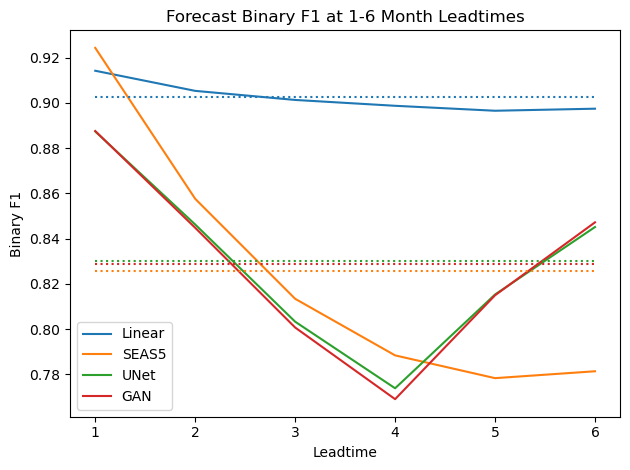

In [7]:
# plot against leadtime
fig, ax = plt.subplots()
binary_f1s_df.drop("All").plot(ax=ax)
for i, model in enumerate(binary_f1s_df.columns):
    plt.hlines(binary_f1s_df[model].loc["All"], xmin=0, xmax=5, colors=tab10(i), linestyles=":")
plt.ylabel("Binary F1")
plt.title("Forecast Binary F1 at 1-6 Month Leadtimes")
plt.tight_layout()
plt.show()

### 4. Compute ternary accuracy
Although binary accuracy is the metric of greatest interest in the original IceNet paper, we choose to investigate ternary accuracy as our UNet and GAN models are trained on three-class data.

Recall that this data comprises `SIC < 15%` (ice-free), `15% ≤ SIC ≤ 85%` (marginal ice), and `SIC > 85%` (full ice).

In [38]:
ternary_accuracies = {"Leadtime": [], "Linear": [], "SEAS5": [], "UNet": [], "GAN": []}

# compute ternary accuracy for individual leadtimes
for leadtime in tqdm(range(1, 7)):
    ternary_accuracies["Leadtime"].append(leadtime)
    ternary_accuracies["Linear"].append(src.ternary_accuracy(linear_forecast, true_forecast, forecast_mask, [leadtime]))
    ternary_accuracies["SEAS5"].append(src.ternary_accuracy(seas5_forecast, true_forecast, forecast_mask, [leadtime]))
    ternary_accuracies["UNet"].append(src.ternary_accuracy(unet_forecast, true_forecast, forecast_mask, [leadtime]))
    ternary_accuracies["GAN"].append(src.ternary_accuracy(gan_forecast, true_forecast, forecast_mask, [leadtime]))

# compute ternary accuracy for all leadtimes
ternary_accuracies["Leadtime"].append("All")
leads = list(range(1, 7))
ternary_accuracies["Linear"].append(src.ternary_accuracy(linear_forecast, true_forecast, forecast_mask, leads))
ternary_accuracies["SEAS5"].append(src.ternary_accuracy(seas5_forecast, true_forecast, forecast_mask, leads))
ternary_accuracies["UNet"].append(src.ternary_accuracy(unet_forecast, true_forecast, forecast_mask, leads))
ternary_accuracies["GAN"].append(src.ternary_accuracy(gan_forecast, true_forecast, forecast_mask, leads))

# construct dataframe
ternary_accuracies_df = pd.DataFrame(ternary_accuracies).set_index("Leadtime")
ternary_accuracies_df

100%|██████████| 6/6 [00:11<00:00,  1.84s/it]


,Linear,SEAS5,UNet,GAN
Leadtime,,,,
1,0.777852,0.778360,0.696818,0.692776
2,0.764714,0.638466,0.626656,0.622218
3,0.757635,0.553836,0.564635,0.556565
4,0.752015,0.501756,0.558225,0.553782
5,0.747653,0.479981,0.638901,0.637253
6,0.752954,0.498333,0.666295,0.671265
All,0.759097,0.578185,0.626044,0.623066


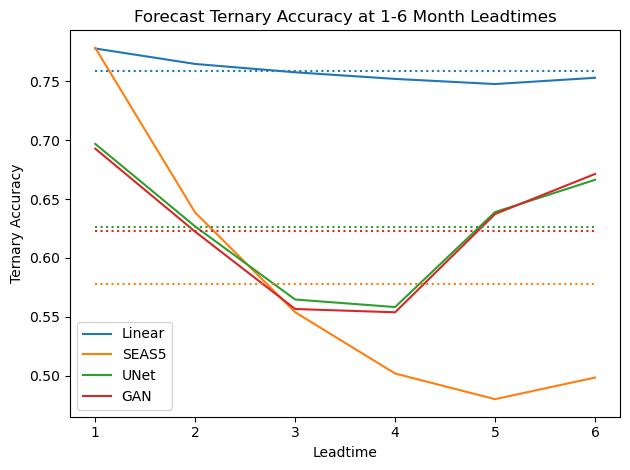

In [47]:
# plot against leadtime
fig, ax = plt.subplots()
ternary_accuracies_df.drop("All").plot(ax=ax)
for i, model in enumerate(ternary_accuracies_df.columns):
    plt.hlines(ternary_accuracies_df[model].loc["All"], xmin=0, xmax=5, colors=tab10(i), linestyles=":")
plt.ylabel("Ternary Accuracy")
plt.title("Forecast Ternary Accuracy at 1-6 Month Leadtimes")
plt.tight_layout()
plt.show()

### 5. Compute ternary F1
Again, given the fact that we trained our UNet and GAN on three-class data, it would not be fair to forego a ternary F1 evaluation.

We'll consider the macro-averaged F1, as macro-averaged metrics give more weight to underrepresented classes.

In [8]:
ternary_f1s = {"Leadtime": [], "Linear": [], "SEAS5": [], "UNet": [], "GAN": []}

# compute ternary f1 for individual leadtimes
for leadtime in tqdm(range(1, 7)):
    ternary_f1s["Leadtime"].append(leadtime)
    ternary_f1s["Linear"].append(src.ternary_f1(linear_forecast, true_forecast, forecast_mask, [leadtime]))
    ternary_f1s["SEAS5"].append(src.ternary_f1(seas5_forecast, true_forecast, forecast_mask, [leadtime]))
    ternary_f1s["UNet"].append(src.ternary_f1(unet_forecast, true_forecast, forecast_mask, [leadtime]))
    ternary_f1s["GAN"].append(src.ternary_f1(gan_forecast, true_forecast, forecast_mask, [leadtime]))

# compute ternary f1 for all leadtimes
ternary_f1s["Leadtime"].append("All")
leads = list(range(1, 7))
ternary_f1s["Linear"].append(src.ternary_f1(linear_forecast, true_forecast, forecast_mask, leads))
ternary_f1s["SEAS5"].append(src.ternary_f1(seas5_forecast, true_forecast, forecast_mask, leads))
ternary_f1s["UNet"].append(src.ternary_f1(unet_forecast, true_forecast, forecast_mask, leads))
ternary_f1s["GAN"].append(src.ternary_f1(gan_forecast, true_forecast, forecast_mask, leads))

# construct dataframe
ternary_f1s_df = pd.DataFrame(ternary_f1s).set_index("Leadtime")
ternary_f1s_df

100%|██████████| 6/6 [00:48<00:00,  8.17s/it]


,Linear,SEAS5,UNet,GAN
Leadtime,,,,
1,0.742061,0.733912,0.631526,0.624656
2,0.734225,0.593762,0.568506,0.562564
3,0.731362,0.512734,0.516935,0.512052
4,0.728084,0.465879,0.514555,0.510976
5,0.722490,0.444989,0.589866,0.589380
6,0.721203,0.459809,0.604774,0.613636
All,0.730483,0.537842,0.571725,0.569608


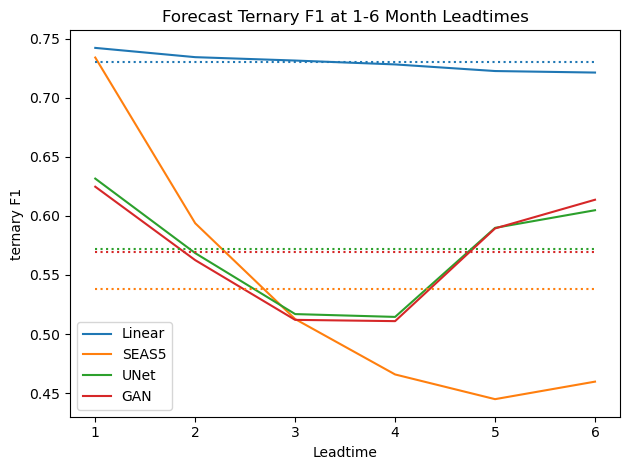

In [9]:
# plot against leadtime
fig, ax = plt.subplots()
ternary_f1s_df.drop("All").plot(ax=ax)
for i, model in enumerate(ternary_f1s_df.columns):
    plt.hlines(ternary_f1s_df[model].loc["All"], xmin=0, xmax=5, colors=tab10(i), linestyles=":")
plt.ylabel("ternary F1")
plt.title("Forecast Ternary F1 at 1-6 Month Leadtimes")
plt.tight_layout()
plt.show()

### 5. Compute SIE error
Next, we'll compute SIE error. This characterises the overall spatial bias of each forecast in a binary sense, measuring the overshoot/undershoot of `SIC > 15%` for a given set of leadtimes.

In [4]:
sie_errors = {"Leadtime": [], "Linear": [], "SEAS5": [], "UNet": [], "GAN": []}

# compute binary f1 for individual leadtimes
for leadtime in tqdm(range(1, 7)):
    sie_errors["Leadtime"].append(leadtime)
    sie_errors["Linear"].append(src.sie_error(linear_forecast, true_forecast, forecast_mask, [leadtime]))
    sie_errors["SEAS5"].append(src.sie_error(seas5_forecast, true_forecast, forecast_mask, [leadtime]))
    sie_errors["UNet"].append(src.sie_error(unet_forecast, true_forecast, forecast_mask, [leadtime]))
    sie_errors["GAN"].append(src.sie_error(gan_forecast, true_forecast, forecast_mask, [leadtime]))

# compute binary f1 for all leadtimes
sie_errors["Leadtime"].append("All")
leads = list(range(1, 7))
sie_errors["Linear"].append(src.sie_error(linear_forecast, true_forecast, forecast_mask, leads))
sie_errors["SEAS5"].append(src.sie_error(seas5_forecast, true_forecast, forecast_mask, leads))
sie_errors["UNet"].append(src.sie_error(unet_forecast, true_forecast, forecast_mask, leads))
sie_errors["GAN"].append(src.sie_error(gan_forecast, true_forecast, forecast_mask, leads))

# construct dataframe
sie_errors_df = pd.DataFrame(sie_errors).set_index("Leadtime")
sie_errors_df

100%|██████████| 6/6 [00:12<00:00,  2.05s/it]


,Linear,SEAS5,UNet,GAN
Leadtime,,,,
1,663566.176471,5.426103e+05,88125.000000,88014.705882
2,839411.764706,1.287279e+06,189705.882353,82500.000000
3,838125.000000,1.532022e+06,76801.470588,48713.235294
4,649154.411765,1.515000e+06,48088.235294,-90992.647059
5,421691.176471,1.346875e+06,-198492.647059,-254301.470588
6,150992.647059,1.112243e+06,-118713.235294,-128161.764706
All,593823.529412,1.222672e+06,14252.450980,-42371.323529


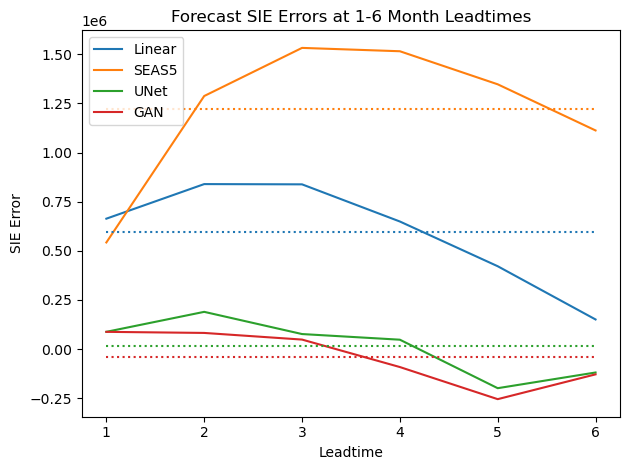

In [5]:
# plot against leadtime
fig, ax = plt.subplots()
sie_errors_df.drop("All").plot(ax=ax)
for i, model in enumerate(sie_errors_df.columns):
    plt.hlines(sie_errors_df[model].loc["All"], xmin=0, xmax=5, colors=tab10(i), linestyles=":")
plt.ylabel("SIE Error")
plt.title("Forecast SIE Errors at 1-6 Month Leadtimes")
plt.tight_layout()
plt.show()

### n. Visualise a summer forecast
To characterise our model forecasts in a more holistic sense, we'll plot the output of a select few full six-month forecasts.

Given that we've trained on ternary data, we'll visualise the forecasts in three-class form.

In particular, we'll plot out a summer forecast (predicting forward from April after the annual maximum occurs in March).

In [87]:
forecast_dict = {
    "Linear": linear_forecast,
    "SEAS5": seas5_forecast,
    "UNet": unet_forecast,
    "GAN": gan_forecast,
}
forecast_dict_with_truth = forecast_dict.copy()
forecast_dict_with_truth["True"] = true_forecast

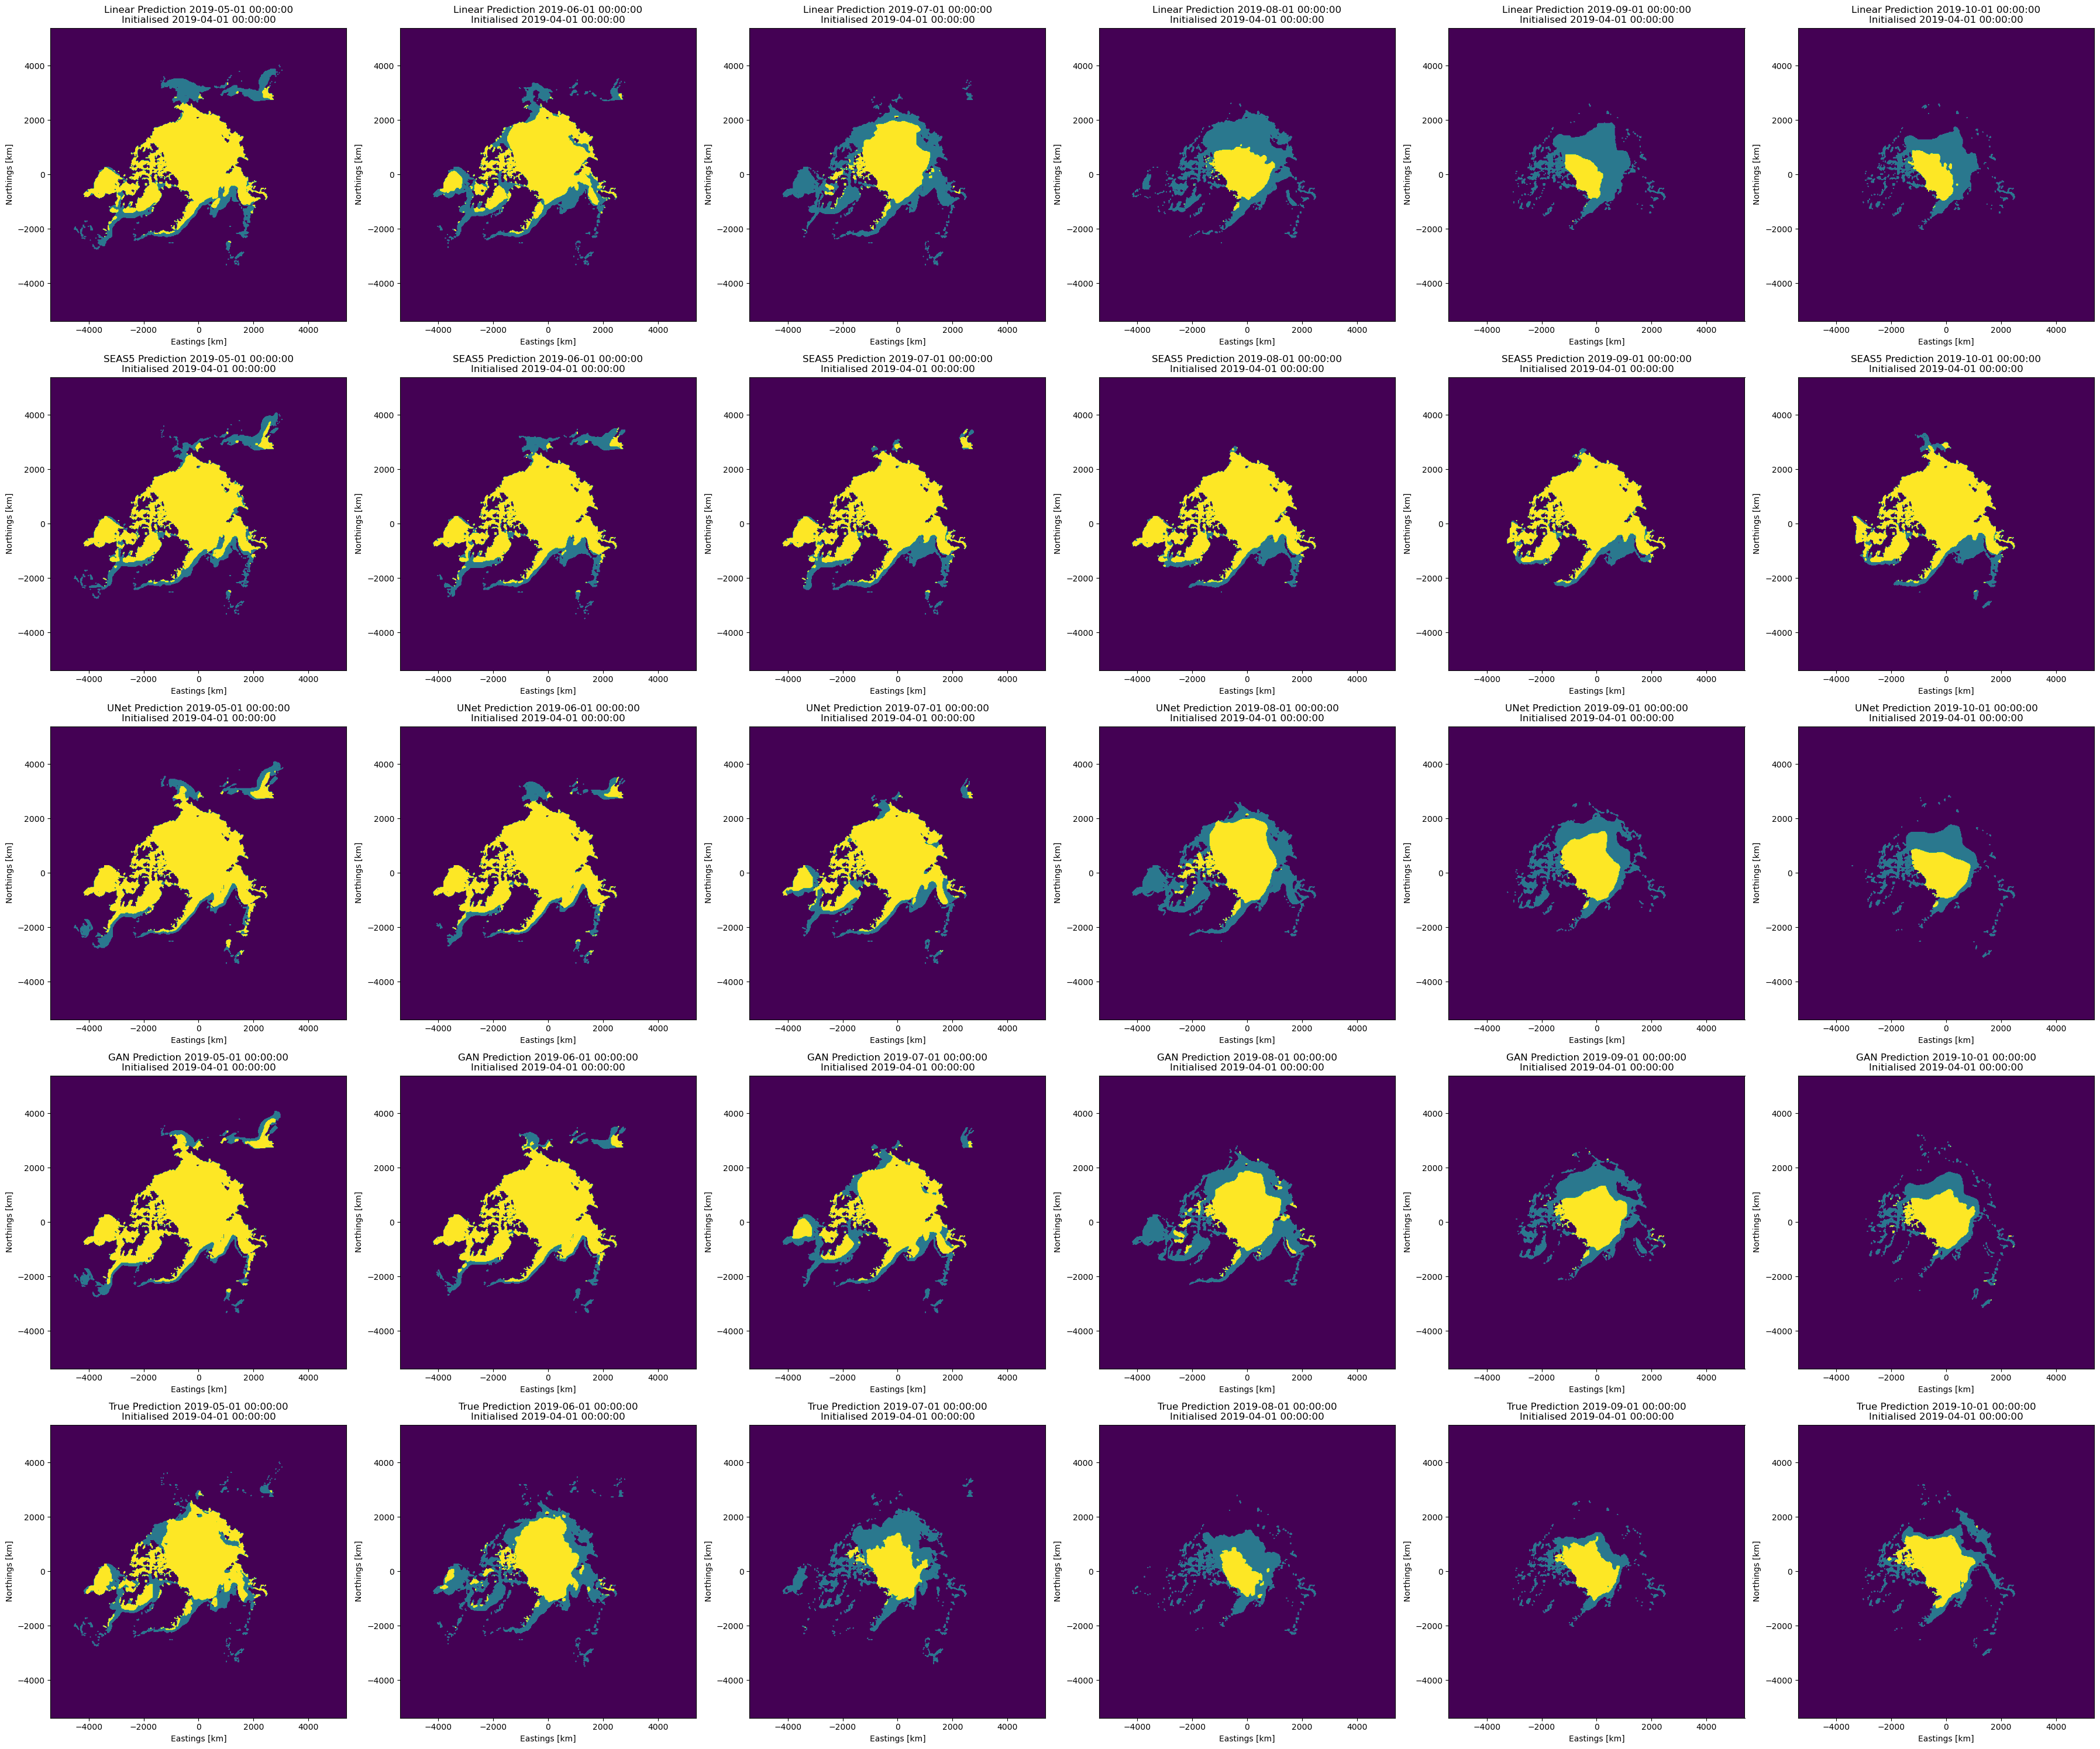

In [88]:
summer = datetime(year=2019, month=4, day=1)
src.visualise_forecast(forecast_dict_with_truth, forecast_mask, summer)

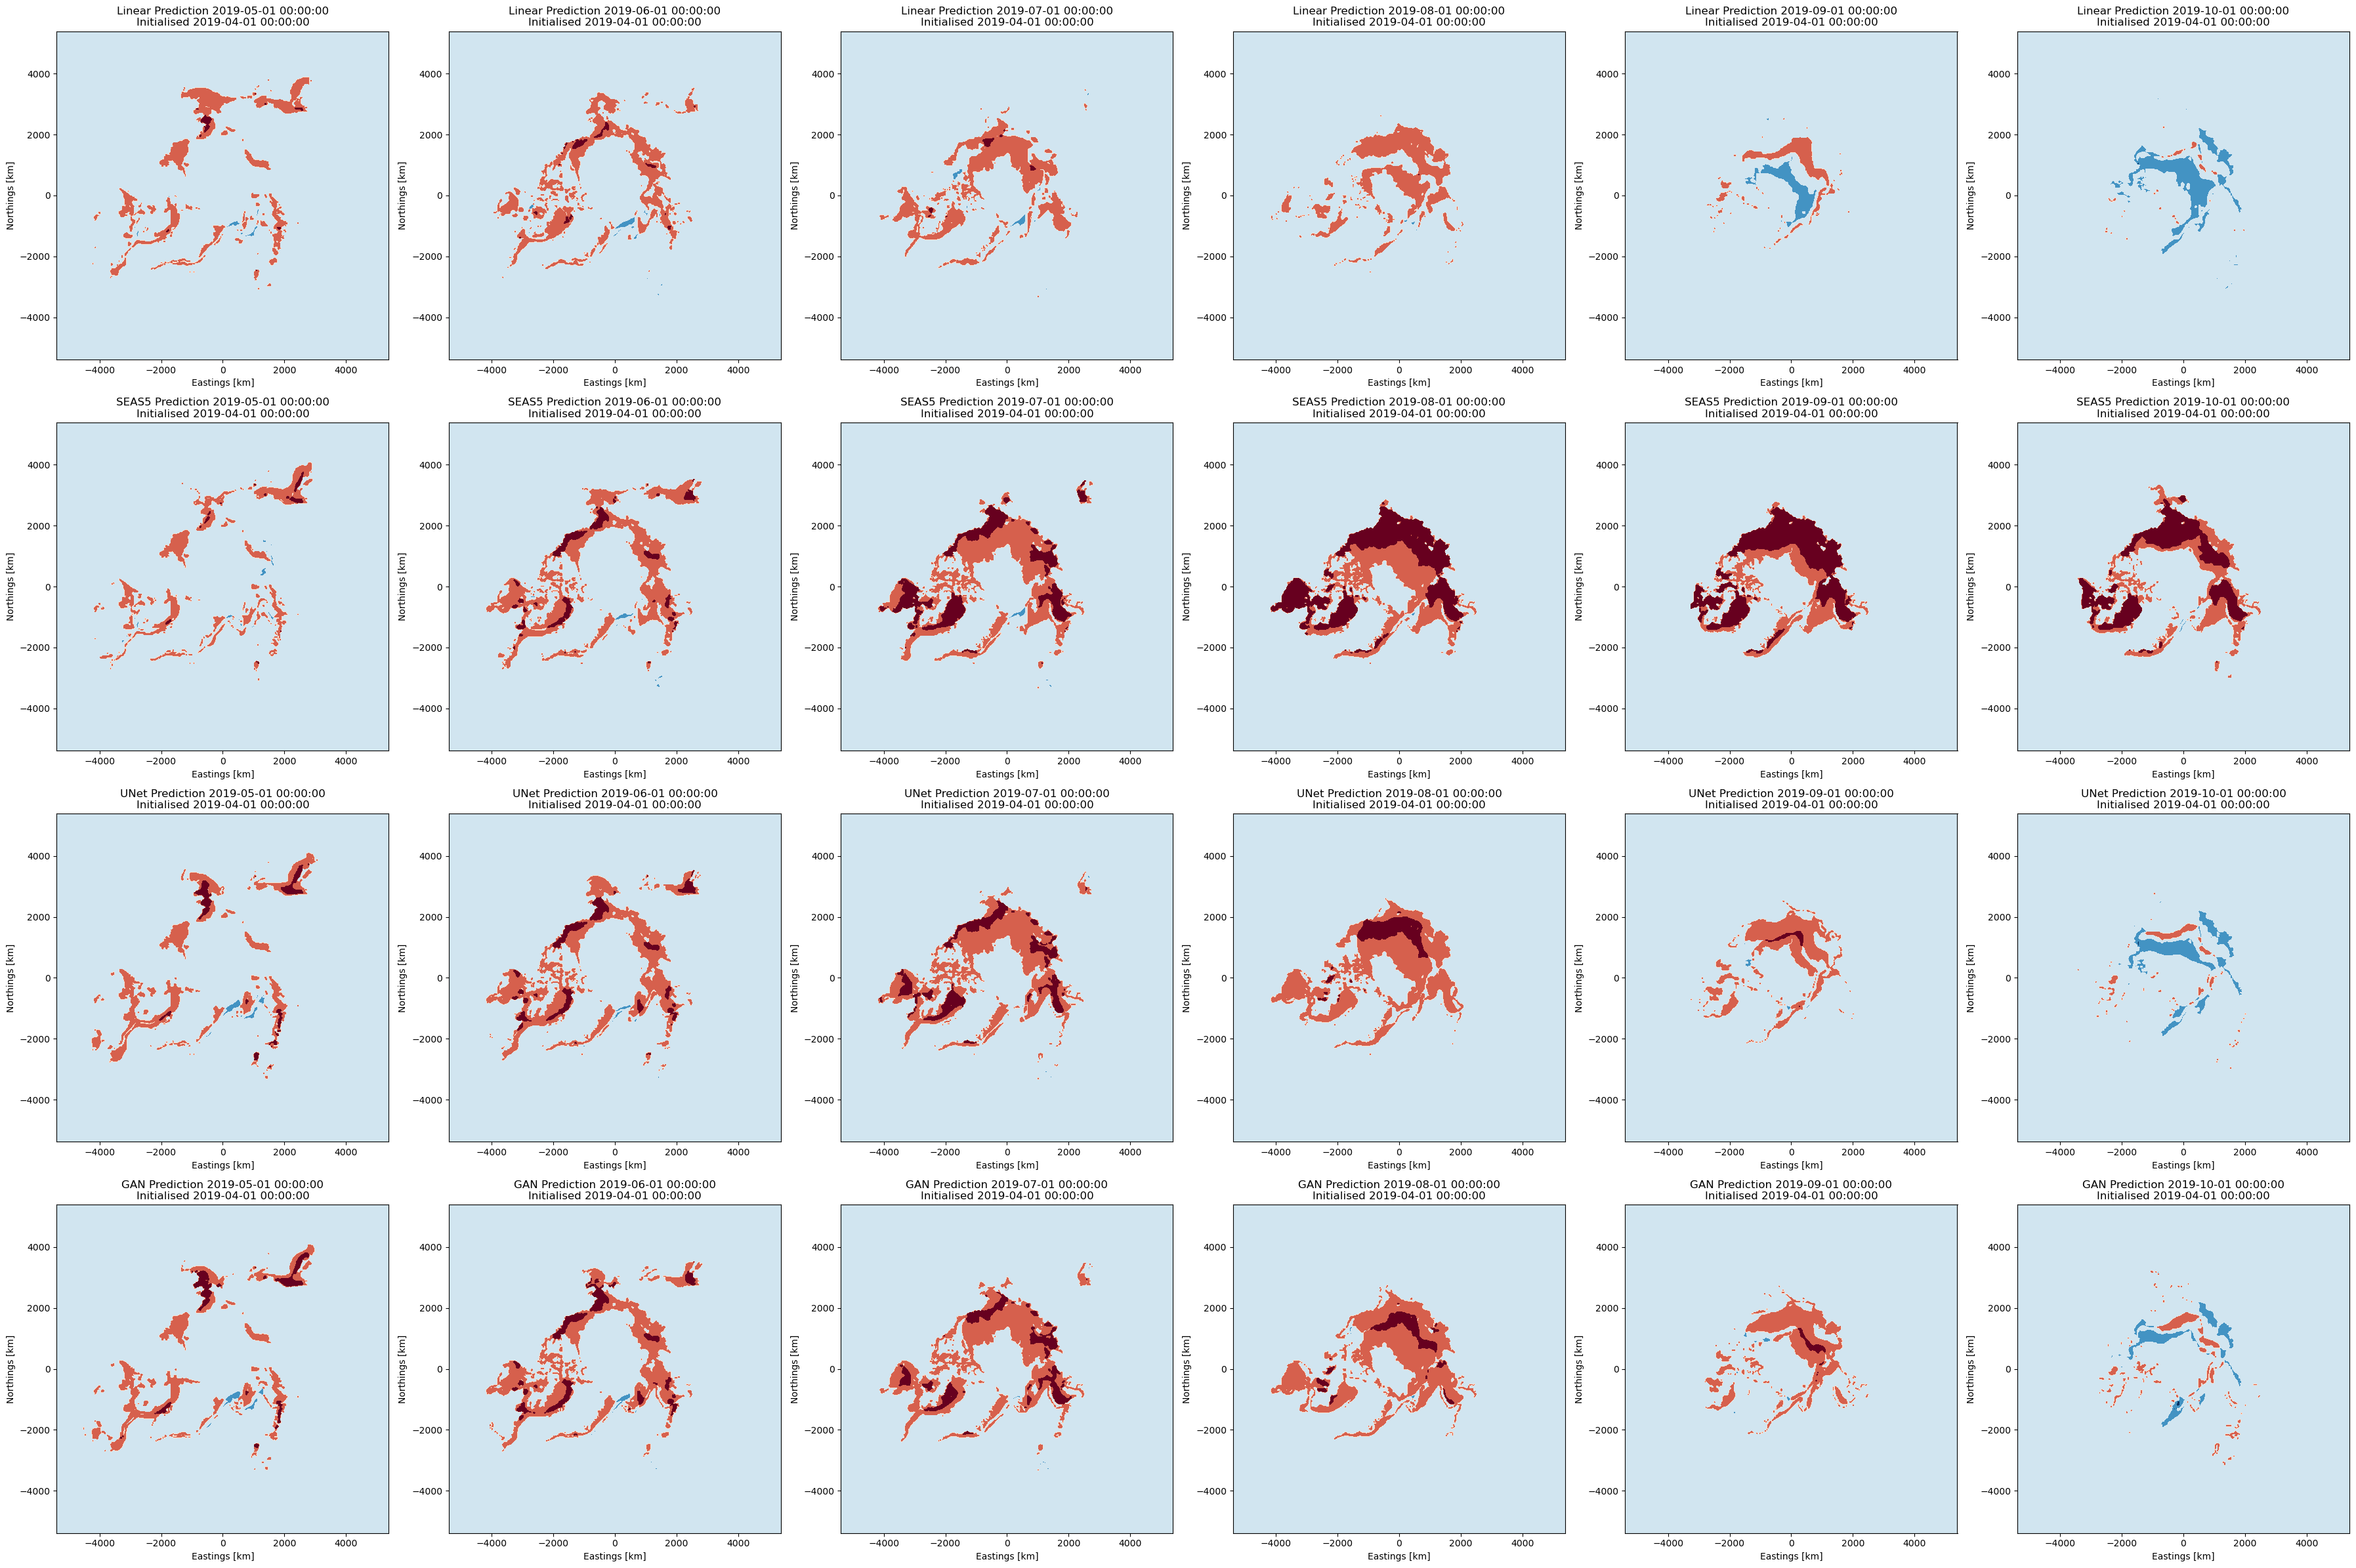

In [89]:
src.visualise_forecast(forecast_dict, forecast_mask, summer, diff=True, true_forecast=true_forecast)

### n. Visualise a winter forecast
Continuing the theme from the previous section, we'll plot an individual winter forecast (predicting forward from October after the annual minimum occurs in September).

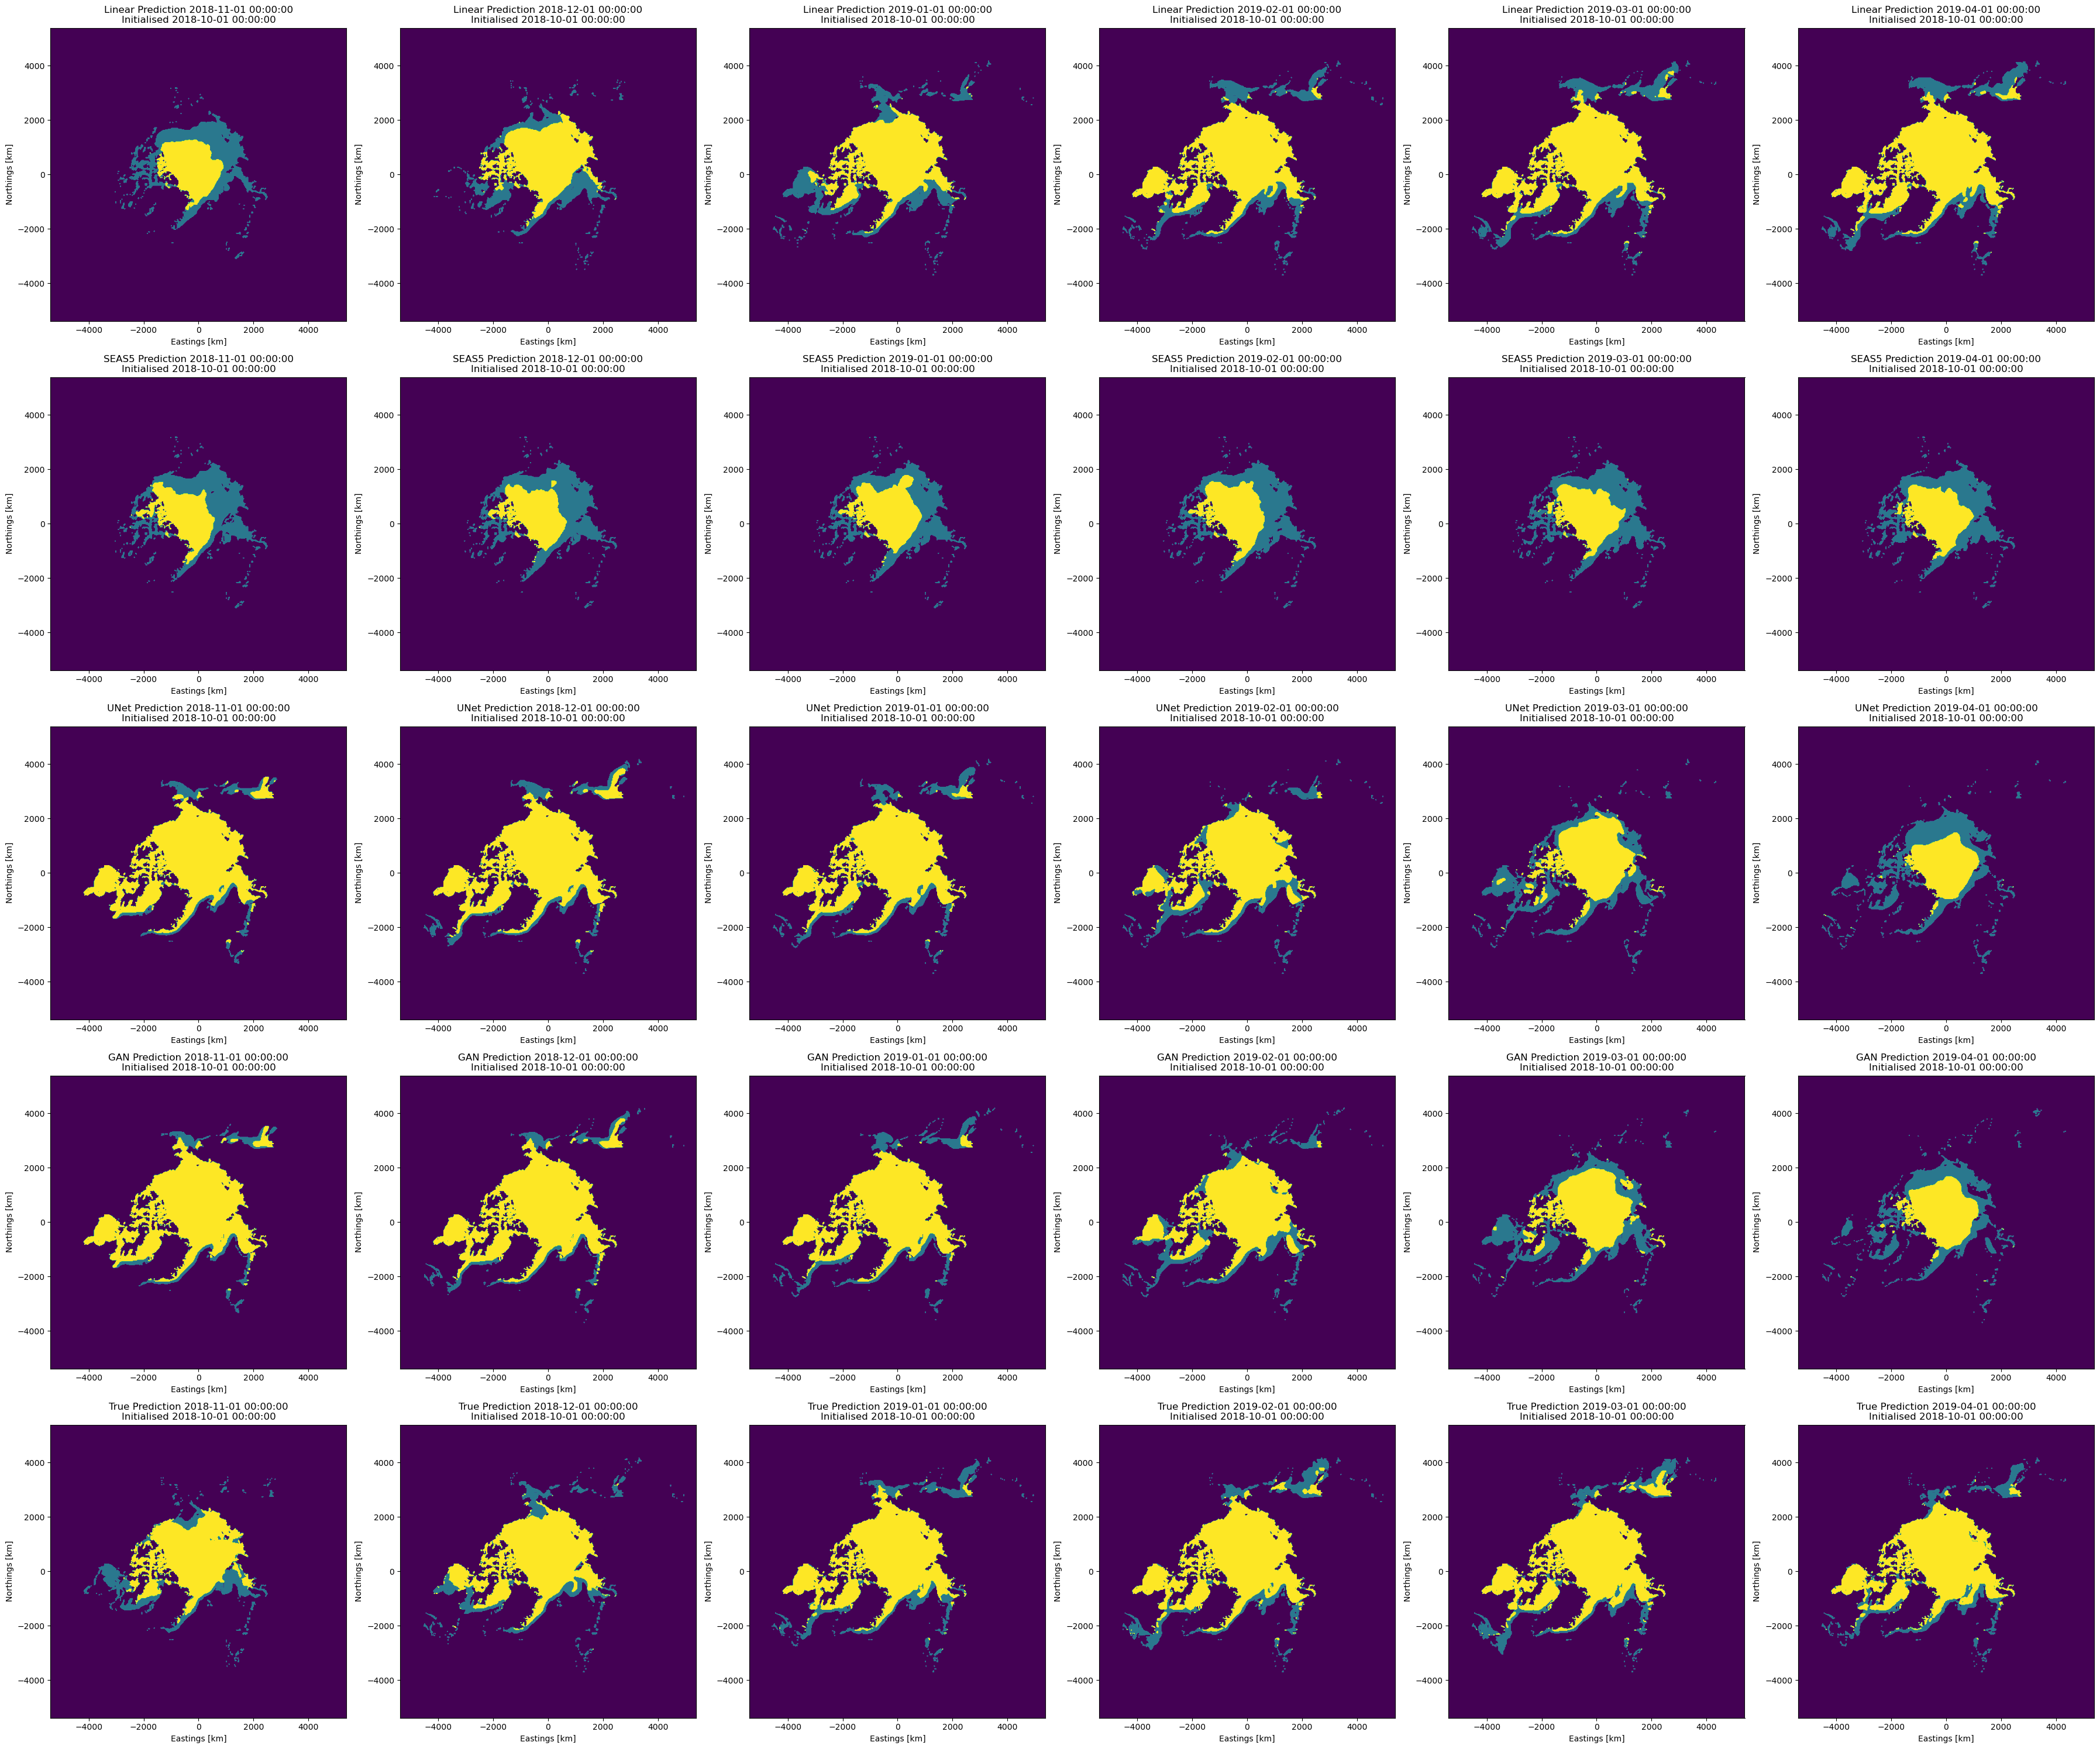

In [90]:
winter = datetime(year=2018, month=10, day=1)
src.visualise_forecast(forecast_dict_with_truth, forecast_mask, winter)

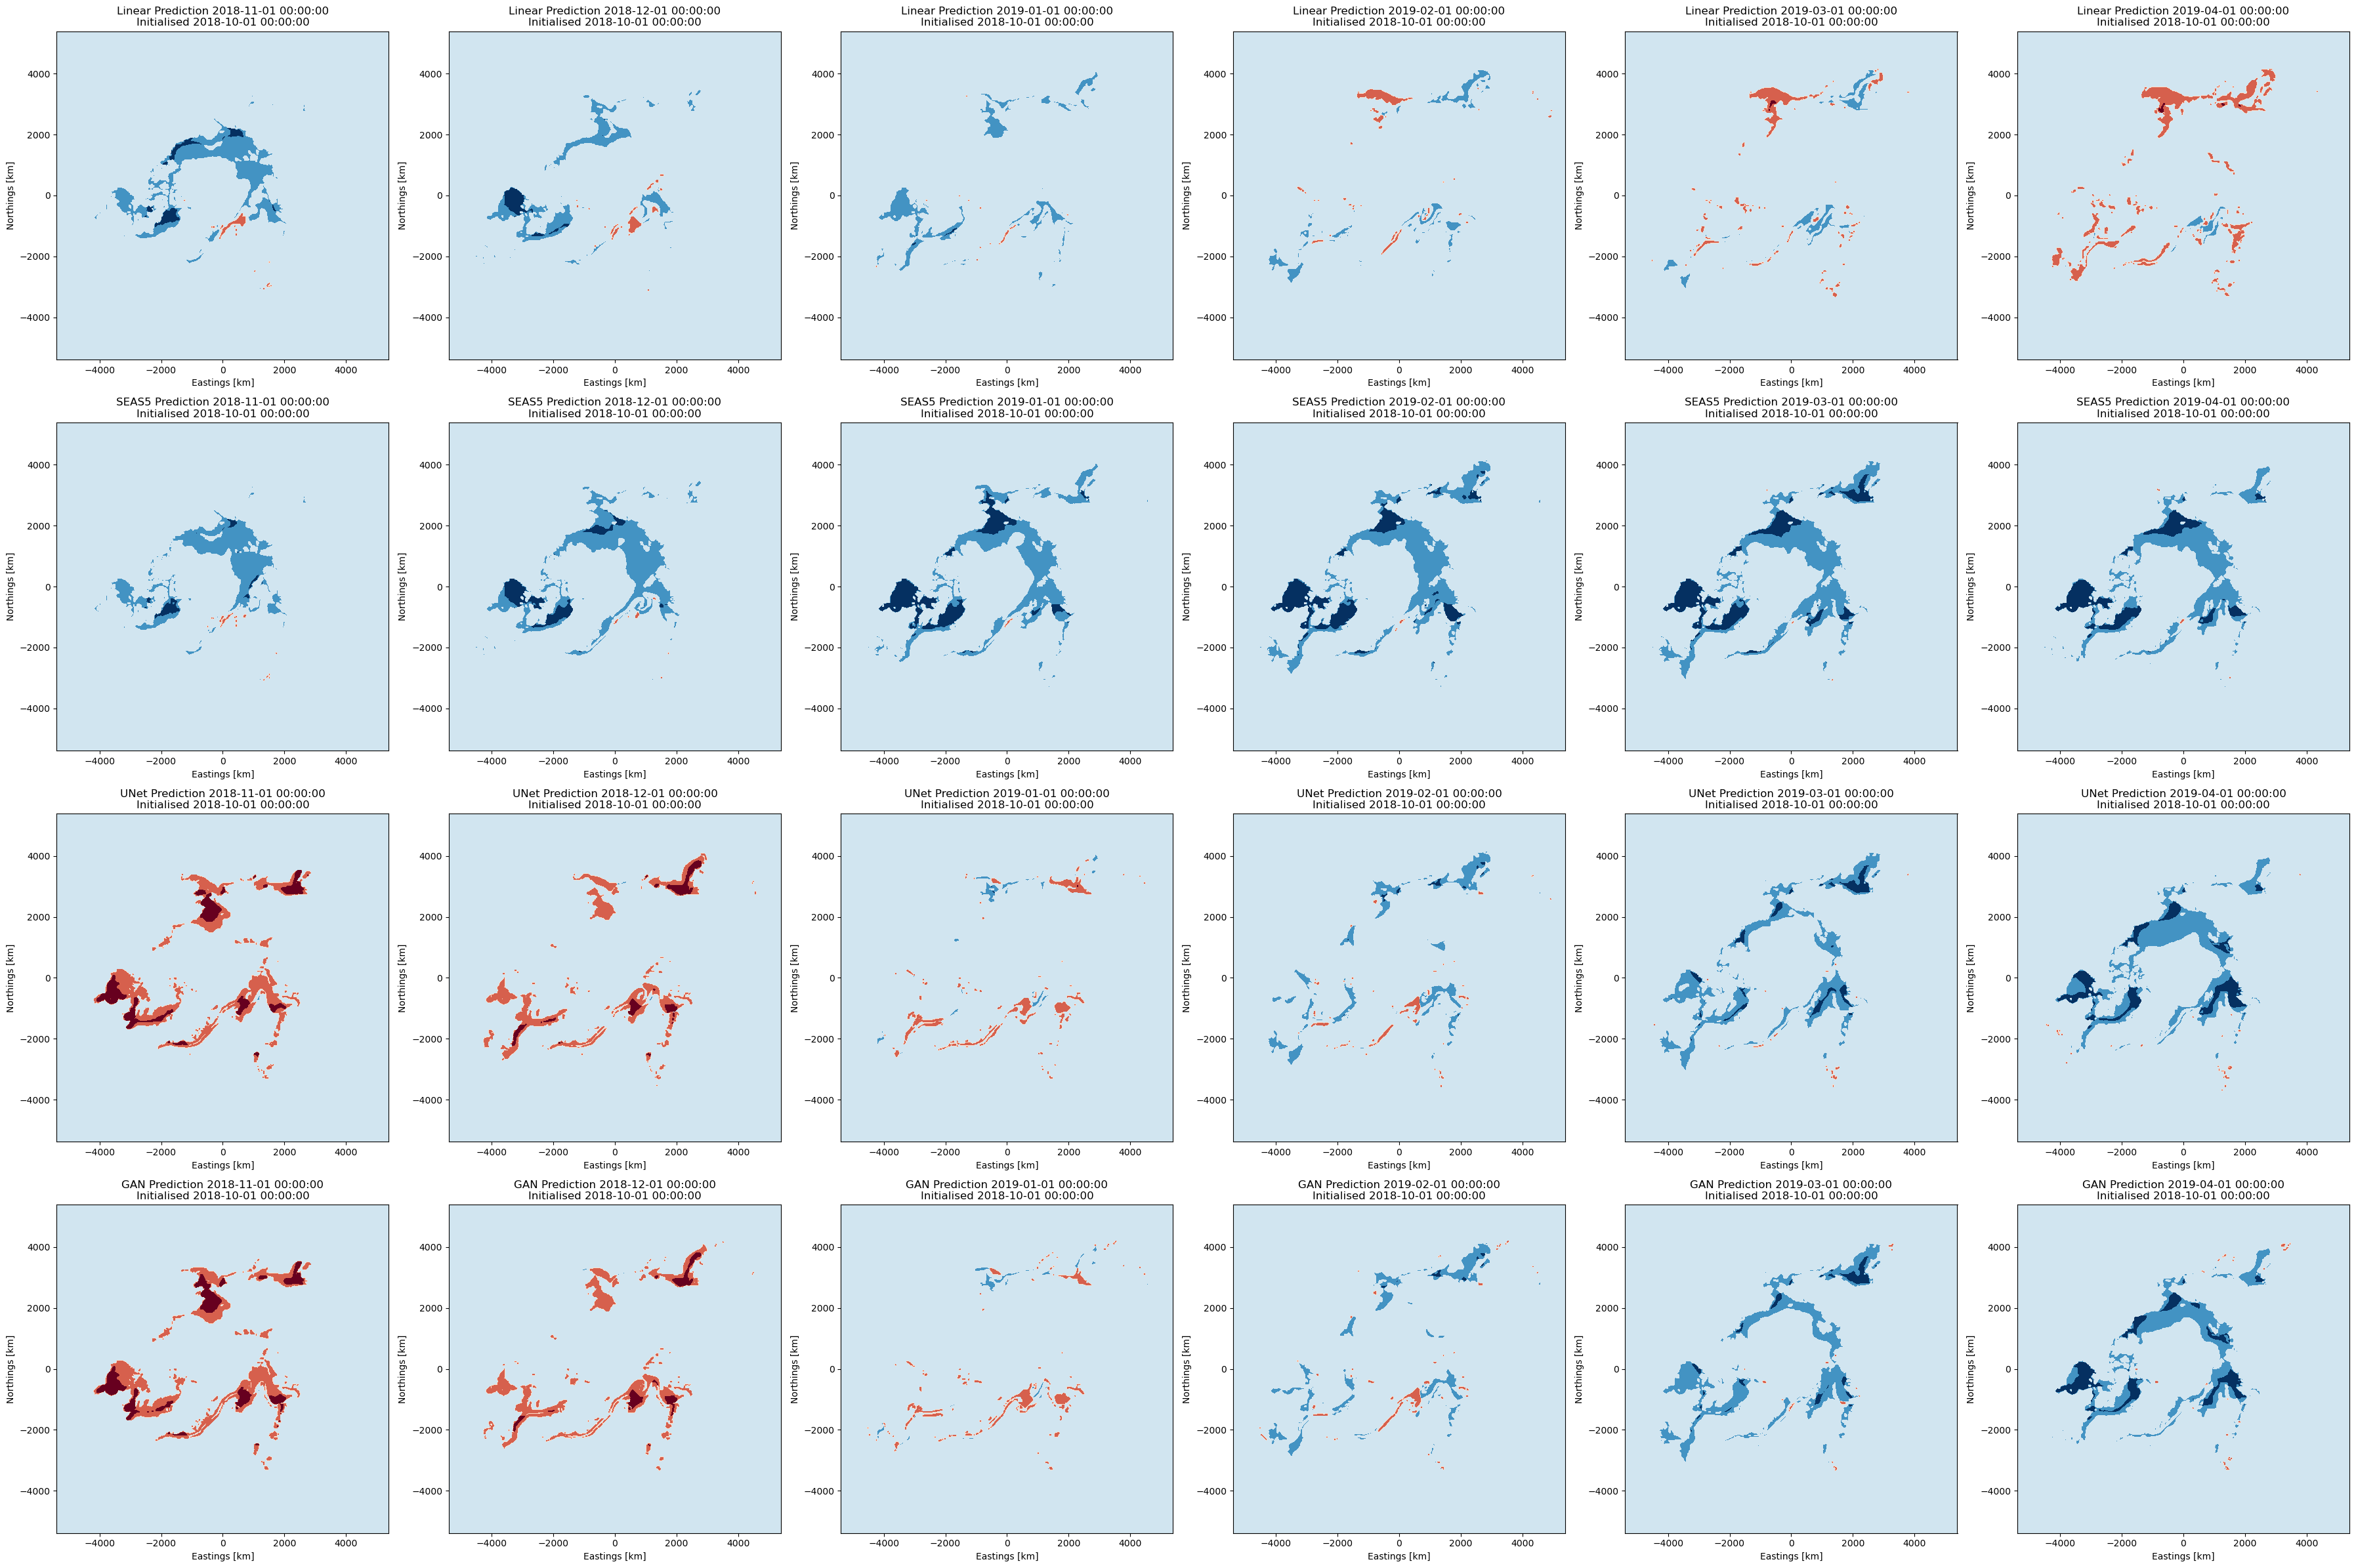

In [91]:
src.visualise_forecast(forecast_dict, forecast_mask, winter, diff=True, true_forecast=true_forecast)

### n. Visualise an unmasked forecast
Our linear model inherently incorporates the land mask in its predictions, as pixels over land are not fit with a linear trend.

Similarly, the SEAS5 model inherently incorporates the land mask in its predictions as a dynamical (physics-based) model.

In contrast, neither our UNet nor GAN models incorporate the land mask in their predictions until the very end, when we take an `argmax` over the logit outputs and manually apply a land mask.

This, in turn, may offer an interesting means of interrogating our UNet and GAN models—visualising their predictions without applying a land mask may provide us with a unique perspective into the model's inner workings.

In [100]:
dl_forecast_dict = {
    "UNet Unmasked": unet_forecast,
    "GAN Unmasked": gan_forecast,
}

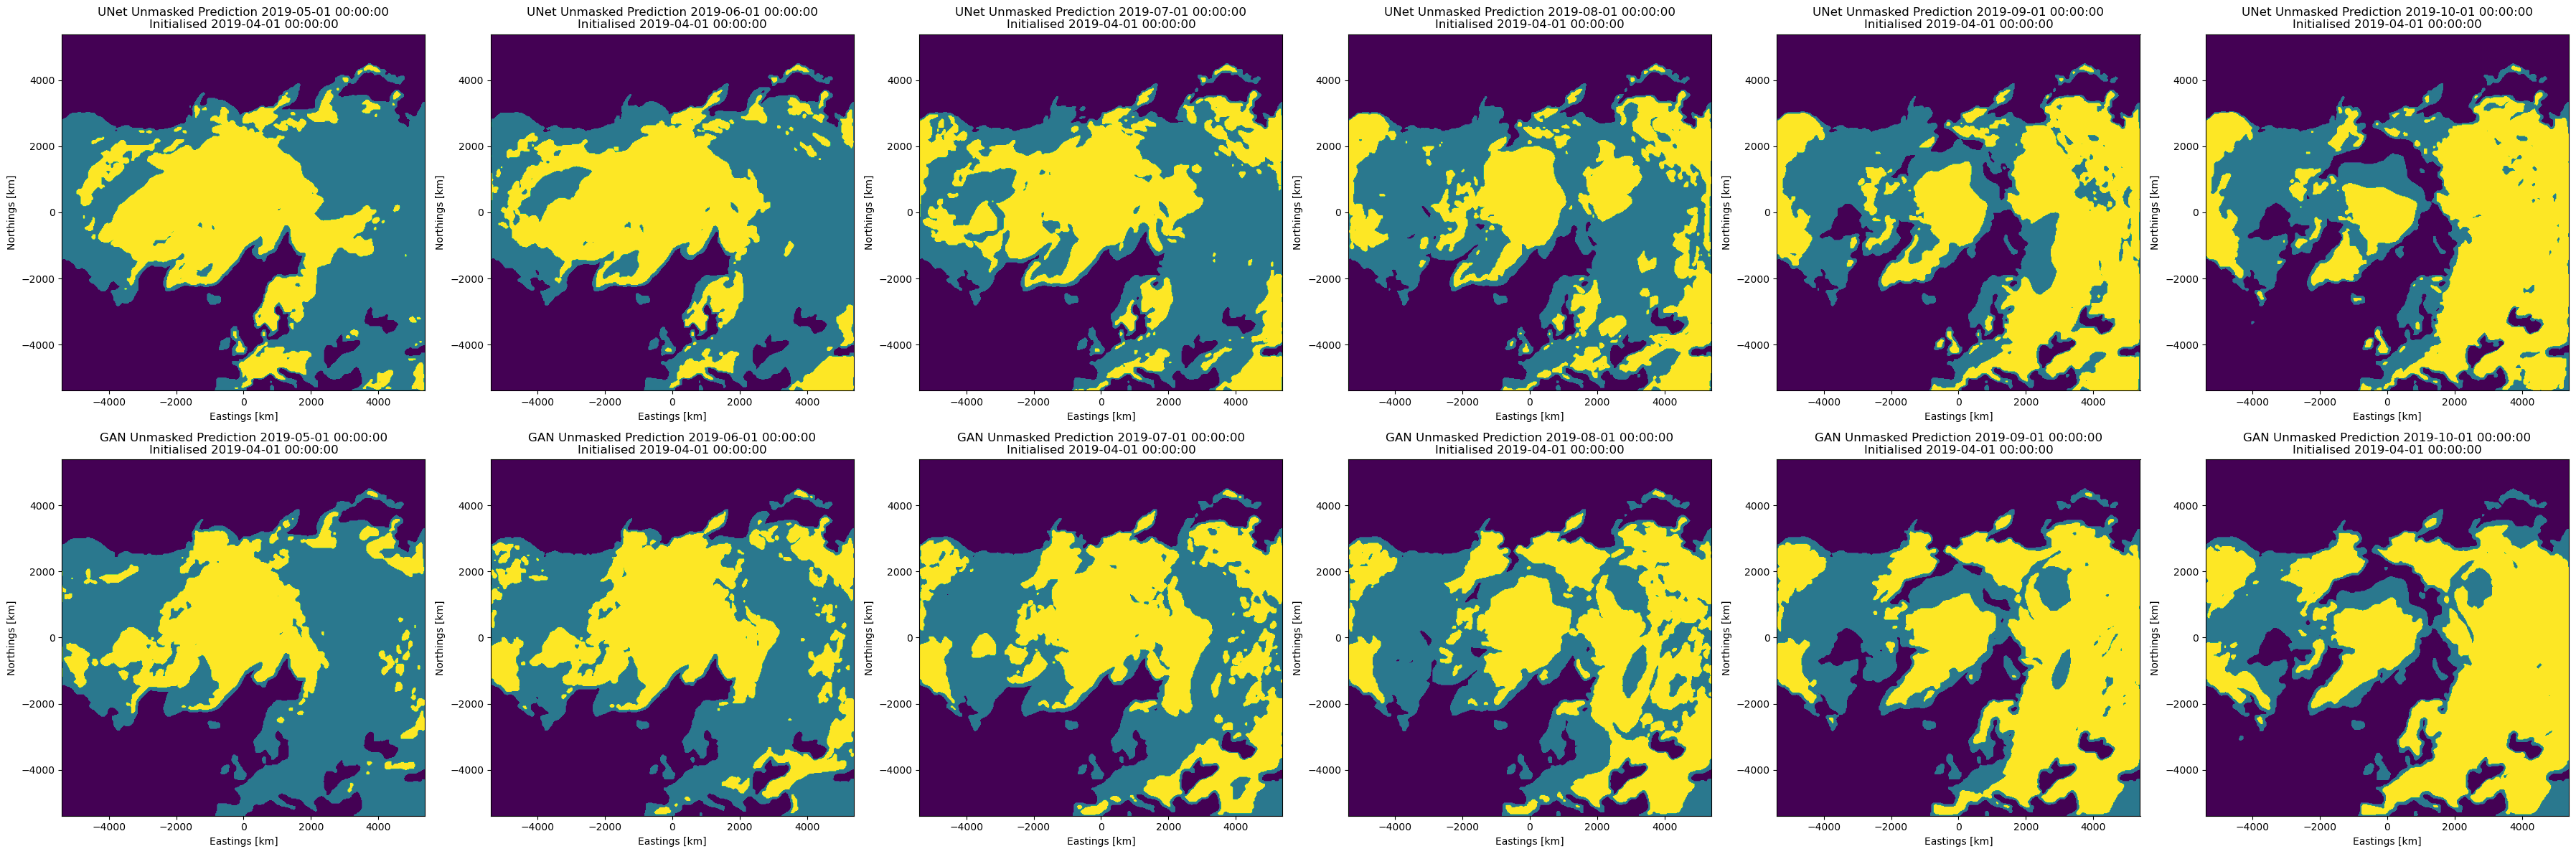

In [101]:
src.visualise_forecast(dl_forecast_dict, xr.ones_like(forecast_mask), summer)

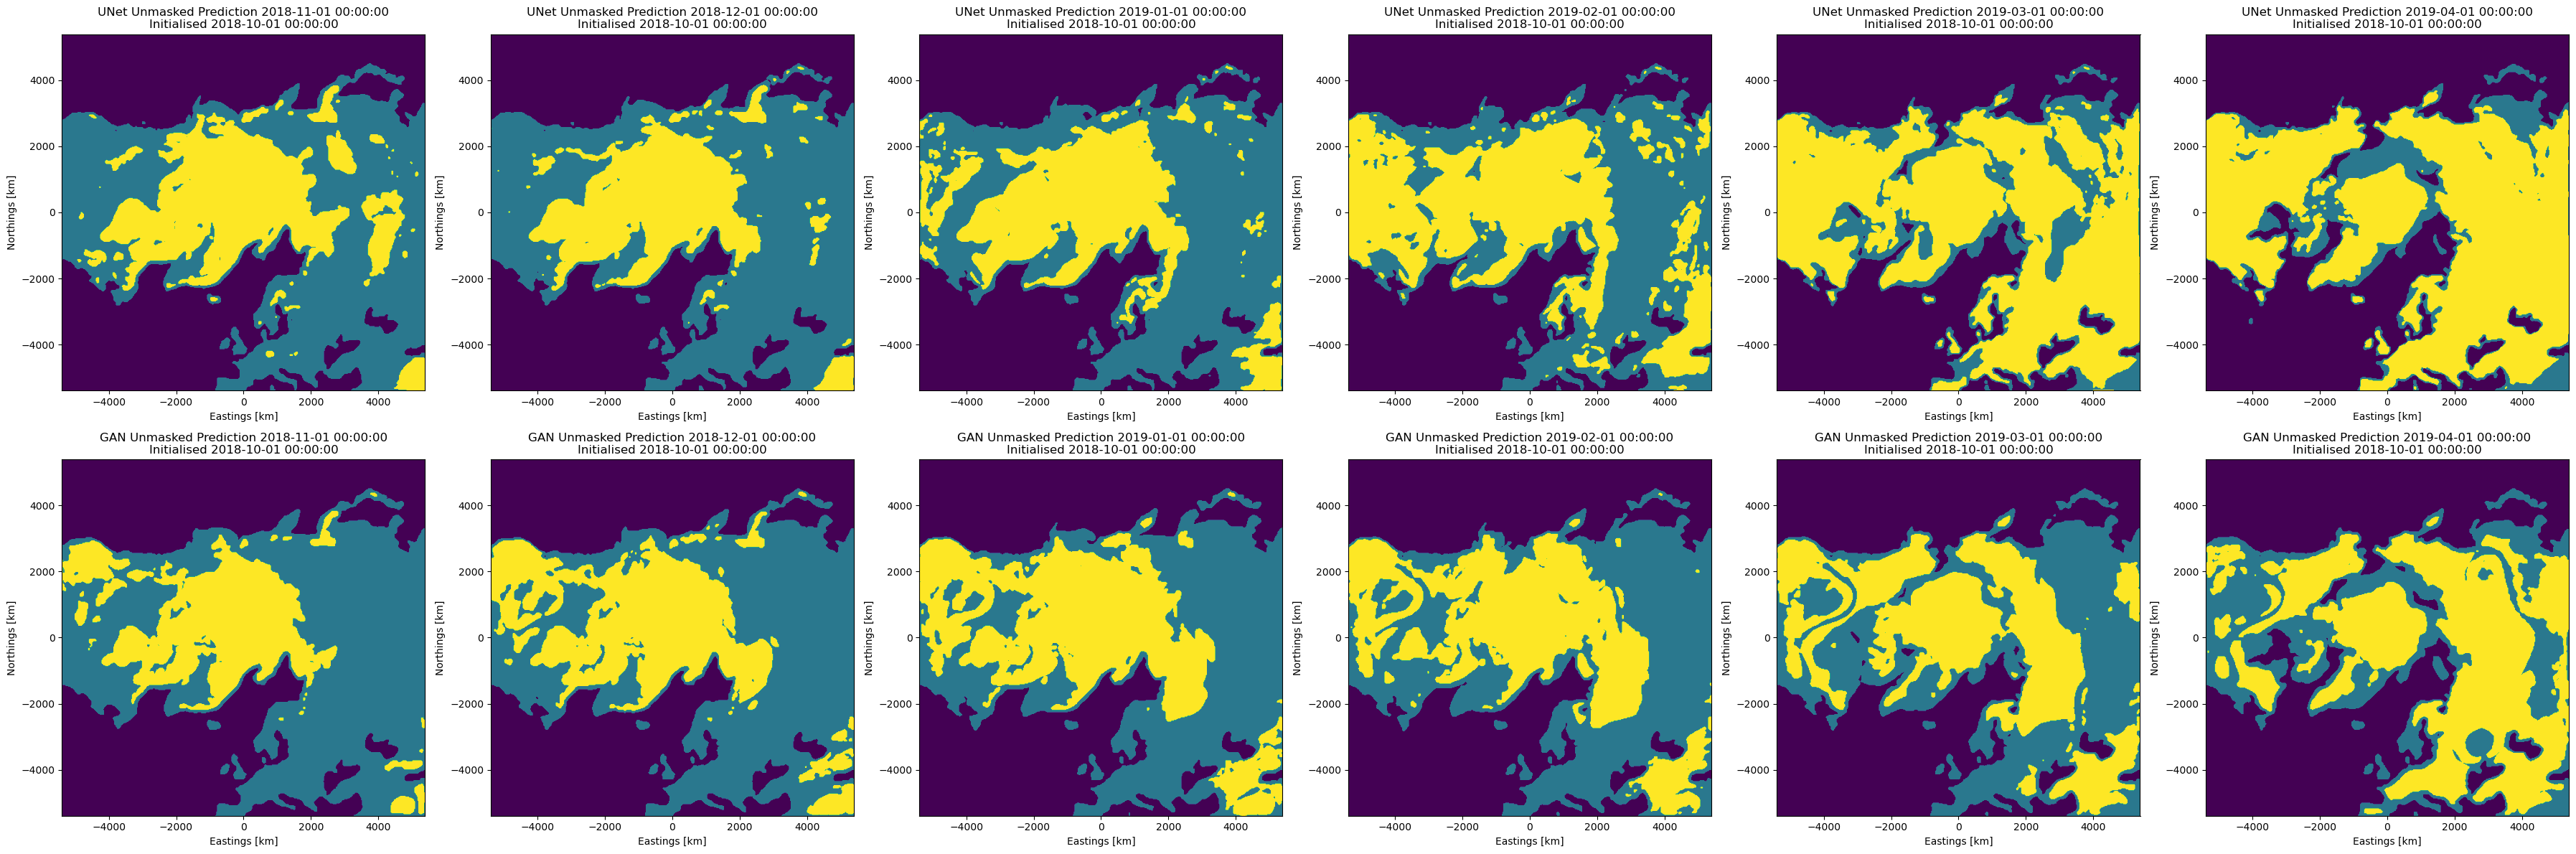

In [103]:
src.visualise_forecast(dl_forecast_dict, xr.ones_like(forecast_mask), winter)

### n. Compute power spectra


In [104]:
gan_forecast.dims

('seed', 'time', 'yc', 'xc', 'leadtime', 'ice_class')

In [110]:
img = gan_forecast.isel(seed=0, time=0, leadtime=1).reduce(np.argmax, dim="ice_class")
spectra = np.fft.fft2(img.values)

In [109]:
spectra

array([[ 1.51623000e+05    +0.j        , -6.91053589e+03 +8887.85304678j,
         3.78042961e+03 +4552.71657259j, ...,
        -6.87475991e+01   +95.77702226j,  3.78042961e+03 -4552.71657259j,
        -6.91053589e+03 -8887.85304678j],
       [-7.01244699e+04-13183.22701413j,  1.96322876e+03+19493.90386442j,
        -4.77596177e+03 -2080.04646619j, ...,
         2.71849419e+03 +1257.02520258j,  1.36930383e+03 -7309.75356279j,
         1.45003988e+04-11878.47325312j],
       [ 5.37355657e+03+19044.8870772j , -9.97995774e+03-12439.24628761j,
         7.94689847e+03 +2266.30839407j, ...,
         4.08962561e+03 -5434.59621479j, -2.53971387e+03+10045.41833573j,
        -2.62388101e+03 +8899.29309935j],
       ...,
       [ 5.83614523e+03-16415.44647959j,  5.43219026e+03 -6114.68957887j,
         5.70037779e+03 +2821.3763072j , ...,
         1.48300337e+02 +2840.09268201j, -2.03095977e+03 -4159.46438092j,
         9.98850287e+02 +7623.36696738j],
       [ 5.37355657e+03-19044.8870772j , -2.